In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')

In [50]:
df = pd.read_csv('Latest_Scrapped_P2P_Notes.csv', index_col=0)

In [51]:
df.head()

,Note_ID,Grade,Rate_%,Effective_Rate_%,Term,PD_%,Funding,Funded_%
0,1101,D8,13.28,23.26,36,10.48,"70,000.00",100.0
1,1099,D8,11.93,21.09,36,10.81,"60,000.00",100.0
2,1098,D8,12.78,22.46,36,11.15,"55,000.00",100.0
3,1096,D7,12.19,21.51,36,6.95,"100,000.00",100.0
4,1095,B4,10.58,19.15,24,3.60,"20,000.00",100.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 952 entries, 0 to 951
Data columns (total 8 columns):
Note_ID             952 non-null int64
Grade               952 non-null object
Rate_%              952 non-null float64
Effective_Rate_%    952 non-null float64
Term                952 non-null int64
PD_%                952 non-null float64
Funding             952 non-null object
Funded_%            952 non-null float64
dtypes: float64(4), int64(2), object(2)
memory usage: 66.9+ KB


In [5]:
df.Funding = df.Funding.apply(lambda x: x.replace(",", ''))
df.Funding = df.Funding.astype('float64')

In [6]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df.Grade = le.fit_transform(df.Grade) + 1

/Users/weeliptan/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


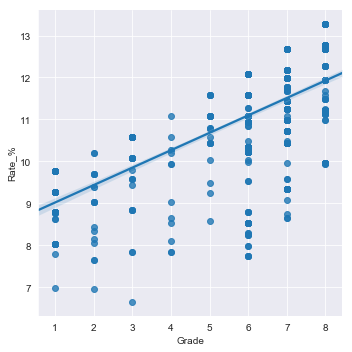

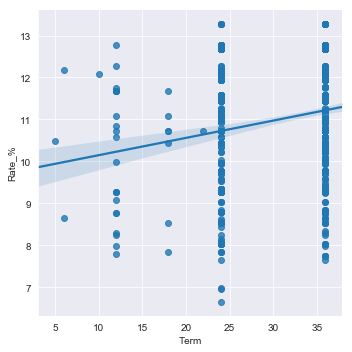

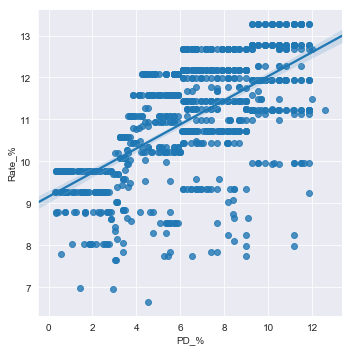

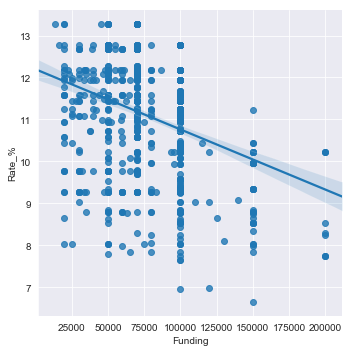

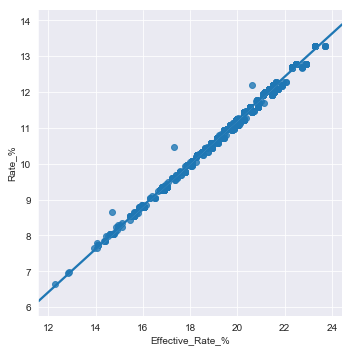

In [7]:
for i in ['Grade', 'Term', 'PD_%', 'Funding', 'Effective_Rate_%']:
    sns.lmplot(i, 'Rate_%', df)
    plt.show()

In [8]:
rows_to_drop = df[df['Funded_%'] < 100].index
df.drop(rows_to_drop, axis = 0, inplace = True)

In [9]:
X = df.drop(['Note_ID', 'Rate_%', 'Effective_Rate_%', 'Funded_%'], axis = 1)
y = df['Rate_%']

In [10]:
X.corr()

,Grade,Term,PD_%,Funding
Grade,1.000000,0.013325,0.893097,0.039734
Term,0.013325,1.000000,0.009657,0.084883
PD_%,0.893097,0.009657,1.000000,0.004774
Funding,0.039734,0.084883,0.004774,1.000000


In [11]:
X = X.drop('Grade', axis = 1)

# Basic Regression Model

In [12]:
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant

In [13]:
final = OLS(y, add_constant(X)).fit()

In [14]:
final.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Rate_%   R-squared:                       0.564
Model:                            OLS   Adj. R-squared:                  0.562
Method:                 Least Squares   F-statistic:                     354.2
Date:                Sat, 08 Feb 2020   Prob (F-statistic):          1.33e-147
Time:                        14:04:49   Log-Likelihood:                -1094.3
No. Observations:                 826   AIC:                             2197.
Df Residuals:                     822   BIC:                             2215.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.9370      0.182     49.075      0.000       8.580       9.294
Term           0.0434      0.005      9.071      0.000       0.034       0.053
PD_%           0.3065      0.011     27.953      0.000       0.285       0.328
Funding    -1.617e-05   1.09e-06    -14.790      0.000   -1.83e-05    -1.4e-05
==============================================================================
Omnibus:                       36.868   Durbin-Watson:                   1.379
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               40.703
Skew:                          -0.521   Prob(JB):                     1.45e-09
Kurtosis:                       3.314   Cond. No.                     4.67e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.67e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [15]:
def predict(x):
    subset = x[['Term', 'PD_%', 'Funding']].values
    add_constant = np.append([1], subset)
    prediction = final.predict(add_constant)
    return round(prediction[0], 2)

def invest_decision(x):
    if x['Delta_%'] >= 1.00:
        return 'Yes'
    else:
        return 'No'

In [16]:
df['Predicted_Rate_%'] = df.apply(predict, axis = 1)
df['Delta_%'] = df['Rate_%'] - df['Predicted_Rate_%']
df['Invest'] = df.apply(invest_decision, axis = 1)

In [17]:
df.head()

,Note_ID,Grade,Rate_%,Effective_Rate_%,Term,PD_%,Funding,Funded_%,Predicted_Rate_%,Delta_%,Invest
0,1101,8,13.28,23.26,36,10.48,70000.0,100.0,12.58,0.70,No
1,1099,8,11.93,21.09,36,10.81,60000.0,100.0,12.84,-0.91,No
2,1098,8,12.78,22.46,36,11.15,55000.0,100.0,13.03,-0.25,No
3,1096,7,12.19,21.51,36,6.95,100000.0,100.0,11.01,1.18,Yes
4,1095,4,10.58,19.15,24,3.60,20000.0,100.0,10.76,-0.18,No


In [19]:
yes_invest = df[df.Invest == 'Yes'].drop('Invest', axis = 1).reset_index(drop = True)
yes_invest.head()

,Note_ID,Grade,Rate_%,Effective_Rate_%,Term,PD_%,Funding,Funded_%,Predicted_Rate_%,Delta_%
0,1096,7,12.19,21.51,36,6.95,100000.0,100.0,11.01,1.18
1,1093,8,12.78,22.46,36,9.25,100000.0,100.0,11.72,1.06
2,1086,6,12.08,21.33,36,5.01,70000.0,100.0,10.90,1.18
3,1075,7,12.69,22.31,36,7.41,70000.0,100.0,11.64,1.05
4,1071,6,12.08,21.33,36,4.85,70000.0,100.0,10.86,1.22


# Construct Recommendation Engine using Cosine Similarity

In [20]:
from sklearn.preprocessing import MinMaxScaler

In [21]:
mm = MinMaxScaler()
yes_invest_scaled = mm.fit_transform(yes_invest.iloc[:, 1:])

In [22]:
test = pd.concat([yes_invest.Note_ID, pd.DataFrame(yes_invest_scaled, columns = yes_invest.columns[1:])], axis = 1)

In [23]:
chosen_id = 742
chosen_array = df[df.Note_ID == chosen_id].iloc[:, 1:10].values[0]
chosen_array

array([5.000e+00, 1.043e+01, 1.863e+01, 3.600e+01, 3.850e+00, 1.500e+05,
       1.000e+02, 9.260e+00, 1.170e+00])

In [24]:
def cosine(x):
    b = x[['Grade', 'Rate_%', 'Effective_Rate_%', 'Term', 'PD_%','Funding', 'Funded_%', 'Predicted_Rate_%', 'Delta_%']].values
    
    dot = np.dot(chosen_array, b)
    norm_chosen = np.linalg.norm(chosen_array)
    norm_b = np.linalg.norm(b)
    cos = dot / (norm_chosen * norm_b)
    
    return cos

In [25]:
test['Cosine'] = test.apply(cosine, axis = 1)

In [26]:
recommendation_id = test.sort_values(by = 'Cosine', ascending = False)[1:6]['Note_ID'].values
recommendation_id

array([388, 698, 946, 742, 151])

In [27]:
df[df.Note_ID.isin(recommendation_id)]

,Note_ID,Grade,Rate_%,Effective_Rate_%,Term,PD_%,Funding,Funded_%,Predicted_Rate_%,Delta_%,Invest
126,946,5,10.43,18.90,24,3.72,150000.0,100.0,8.69,1.74,Yes
284,742,5,10.43,18.63,36,3.85,150000.0,100.0,9.26,1.17,Yes
321,698,6,10.23,18.55,24,5.35,150000.0,100.0,9.19,1.04,Yes
567,388,6,10.23,18.30,36,4.99,200000.0,100.0,8.80,1.43,Yes
801,151,5,10.79,19.51,24,3.85,100000.0,100.0,9.54,1.25,Yes
